### **Load libraries**

In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import importlib

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.api import VAR

import itertools
import random

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Load data**

In [4]:
rets = pd.read_csv('all_rets.csv', index_col=0)
stocks = pd.read_csv('all_stocks.csv', index_col=0)

rets.index = pd.to_datetime(rets.index).to_period('W')
stocks.index = pd.to_datetime(stocks.index).to_period('W')

In [5]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 54

In [6]:
# Define start and end dates of the analysis
days_of_analysis = 365*10   # 5 years
end_date = str(datetime.date.today())
start_date = str(datetime.date.today() - datetime.timedelta(days=days_of_analysis))

In [7]:
rets = rets.loc[start_date:end_date]
stocks = stocks.loc[start_date:end_date]

### **Preprocessing - Analysis of stationarity**

In [8]:
# Analysis of stationarity for the whole series
for stock in rets.columns:
    print(f'Augmented Dickey Fuller Test p-value for non-stationarity of level {stock} series: {round(adfuller(rets[stock])[1], 4)}')

Augmented Dickey Fuller Test p-value for non-stationarity of level BCOLOMBIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BOGOTA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BVC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CELSIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CEMARGOS.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CNEC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CONCONCRET.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CORFICOLCF.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ECOPETROL.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ENKA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ETB.CL series: 0.0
Augmented Dicke

In [9]:
# Generate train, validation and test sets to evaluate the accuracy of the model
# 1st The model will be modeled based on the train data initially
# 2nd The model will be fine tuned based on accuracy results with the validation set
# 3rd it will be evaluated with the test set

train_rets = rets.iloc[:-8].copy()
val_rets = rets.iloc[-8:].copy()

### **Initial examination**

In [10]:
# Explore how some of these variables correlate with the first lag of other variables
correlations = rk.corr_vars_vs_lags(train_rets, n_lags=20)

In [11]:
(correlations['PFGRUPSURA.CL'].iloc[1].sort_values(ascending=True)
)

PFGRUPSURA.CL   -0.091183
GOOGL           -0.079521
NVDA            -0.056297
AAPL            -0.053848
EXITO.CL        -0.047088
GRUPOSURA.CL    -0.035359
MINEROS.CL      -0.034694
VOO             -0.034268
CEMARGOS.CL     -0.026975
BOGOTA.CL       -0.025681
FALABELLA.SN    -0.025229
F               -0.023160
CENCOSUD.SN     -0.020345
GE              -0.020066
ENKA.CL         -0.012784
GRUPOAVAL.CL    -0.012639
META            -0.011780
JNJ             -0.009175
GRUBOLIVAR.CL   -0.008864
ETB.CL          -0.002812
JETS            -0.001569
AMZN            -0.000561
PFGRUPOARG.CL    0.008645
NKE              0.012112
SGLD.L           0.013653
JPM              0.015898
BAC              0.017158
C                0.019281
BRK-B            0.022119
CONCONCRET.CL    0.024369
GRUPOARGOS.CL    0.027594
BVC.CL           0.029834
EIMI.L           0.036467
CELSIA.CL        0.039422
CSPX.L           0.042028
NUTRESA.CL       0.043146
BCOLOMBIA.CL     0.048889
CHILE.SN         0.048963
TERPEL.CL   

In [12]:
# Identify the stocks with the highest and lowest average correlation with the 1st lag of other stocks
mean_correlations_1st_lag = {}
for var in correlations:
    mean_correlations_1st_lag[var] = abs(correlations[var].iloc[1:5]).mean().mean()
mean_correlations_1st_lag = pd.Series(mean_correlations_1st_lag).sort_values(ascending=False)
mean_correlations_1st_lag

CONCONCRET.CL    0.122721
GRUPOARGOS.CL    0.069060
ECOPETROL.CL     0.062221
CHILE.SN         0.055878
PFCORFICOL.CL    0.055337
BAC              0.053811
JPM              0.053405
CEMARGOS.CL      0.053038
C                0.052834
JETS             0.052828
PFGRUPOARG.CL    0.052062
F                0.051115
GRUPOSURA.CL     0.050360
NUTRESA.CL       0.050311
HCOLSEL.CL       0.049899
EXITO.CL         0.048709
CSPX.L           0.048231
BCOLOMBIA.CL     0.048125
FALABELLA.SN     0.047723
ICOLCAP.CL       0.047480
ISA.CL           0.047119
PROMIGAS.CL      0.046784
META             0.046744
NKE              0.046393
GRUBOLIVAR.CL    0.046162
GEB.CL           0.045960
CBU7.L           0.045152
JNJ              0.044921
TERPEL.CL        0.044485
BOGOTA.CL        0.044336
PFBCOLOM.CL      0.043848
CORFICOLCF.CL    0.043759
GOOGL            0.043476
PFGRUPSURA.CL    0.043180
PBR              0.043020
VOO              0.042648
GE               0.042082
CENCOSUD.SN      0.042050
SGLD.L      

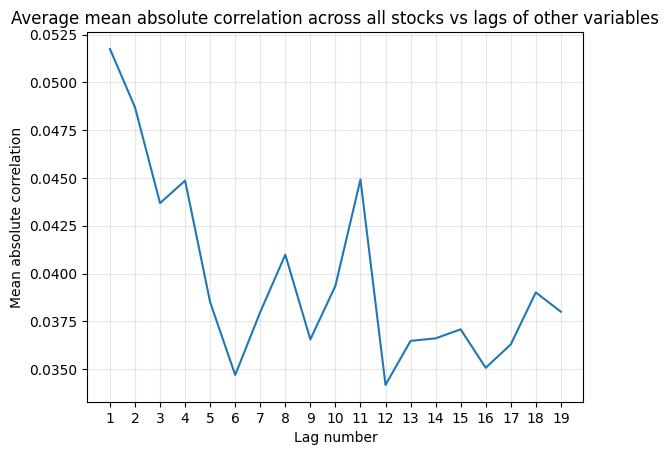

In [13]:
# Identify the number of lags that suggest relevant information across all variables
mean_lags = []
for lag in range(20):
    mean_correlations_n_lag = {}
    for var in correlations:
        mean_correlations_n_lag[var] = abs(correlations[var].iloc[lag]).mean().mean()
    mean_lags.append(pd.Series(mean_correlations_n_lag))
mean_lags = pd.concat(mean_lags, axis=1).mean(0)

# Visualize the results
mean_lags.iloc[1:].plot()
plt.grid(alpha=.3)
plt.title('Average mean absolute correlation across all stocks vs lags of other variables')
plt.ylabel('Mean absolute correlation')
plt.xlabel('Lag number')
plt.xticks(np.arange(1, 20))
plt.show()

### **VAR bagging**

In [14]:
start_value = train_rets.iloc[0].copy()
train_rets_integrated = (train_rets - train_rets.shift(1)).dropna()

In [33]:
symbols_list = list(train_rets.columns.values) # List of all available stock symbols
n_iterations = 2000 # The number of iterations of VAR models to perform
set_size = 15 # Number of symbols modeled in each iteration
periods_to_forecast = 8 # Number of periods to forecast

# Initialize an empty list of sets of stock symbols
iterations_symbols = []

for i in range(n_iterations):
    # For each iteration of the model, select a random set of 'set_size' stock symbols
    iterations_symbols.append(random.sample(symbols_list, set_size))

In [34]:
# Initialize a dictionary of dictionaries where the results of each iteration will be stored
prediction_results = {symbol: {} for symbol in symbols_list}

for i, symbols_selection in enumerate(iterations_symbols):
    subset_df = train_rets_integrated[symbols_selection]
    # Compare the IC (Information Criteria) scores for VAR models of various number of lags to select the ideal number of lags
    varmod = VAR(subset_df)
    lag_sel = varmod.select_order(15)
    # Select the best number of lags according to the AIC criterion
    n_lags = lag_sel.aic
    print(f'Iteration {i}, ideal_n_lags: {n_lags}')
    # Fit the model for the iteration
    var_model = VAR(subset_df).fit(maxlags=n_lags, trend='c')
    predictions = var_model.forecast(subset_df.iloc[-n_lags:].values, periods_to_forecast)
    predictions = pd.DataFrame(predictions)
    for l in predictions:
        prediction_results[symbols_selection[l]][i] = predictions[l]
    print(f'Iteration {i+1} finished')

Iteration 0, ideal_n_lags: 14
Iteration 1 finished
Iteration 1, ideal_n_lags: 6
Iteration 2 finished
Iteration 2, ideal_n_lags: 15
Iteration 3 finished
Iteration 3, ideal_n_lags: 8
Iteration 4 finished
Iteration 4, ideal_n_lags: 14
Iteration 5 finished
Iteration 5, ideal_n_lags: 6
Iteration 6 finished
Iteration 6, ideal_n_lags: 8
Iteration 7 finished
Iteration 7, ideal_n_lags: 14
Iteration 8 finished
Iteration 8, ideal_n_lags: 6
Iteration 9 finished
Iteration 9, ideal_n_lags: 8
Iteration 10 finished
Iteration 10, ideal_n_lags: 6
Iteration 11 finished
Iteration 11, ideal_n_lags: 15
Iteration 12 finished
Iteration 12, ideal_n_lags: 15
Iteration 13 finished
Iteration 13, ideal_n_lags: 6
Iteration 14 finished
Iteration 14, ideal_n_lags: 7
Iteration 15 finished
Iteration 15, ideal_n_lags: 15
Iteration 16 finished
Iteration 16, ideal_n_lags: 10
Iteration 17 finished
Iteration 17, ideal_n_lags: 8
Iteration 18 finished
Iteration 18, ideal_n_lags: 15
Iteration 19 finished
Iteration 19, ideal_n_

In [17]:
import warnings
warnings.filterwarnings('ignore')

prediction_results_processed = prediction_results.copy()
for symbol in prediction_results:
    pred_df = pd.DataFrame(prediction_results[symbol])
    pred_series = pred_df.mean(axis=1)
    pred_series = train_rets[symbol][-1] + pred_series.cumsum()
    pred_series.index = val_rets.index
    #pred_series = rk.invert_transformation(train_rets[symbol][-1], pred_series)
    prediction_results_processed[symbol] = pred_series

In [18]:
symbol = 'AAPL'
prediction_results_processed[symbol]

Date
2025-02-03/2025-02-09    0.007153
2025-02-10/2025-02-16    0.008713
2025-02-17/2025-02-23    0.014227
2025-02-24/2025-03-02   -0.001269
2025-03-03/2025-03-09   -0.012332
2025-03-10/2025-03-16    0.002637
2025-03-17/2025-03-23   -0.010138
2025-03-24/2025-03-30    0.000442
Freq: W-SUN, dtype: float64

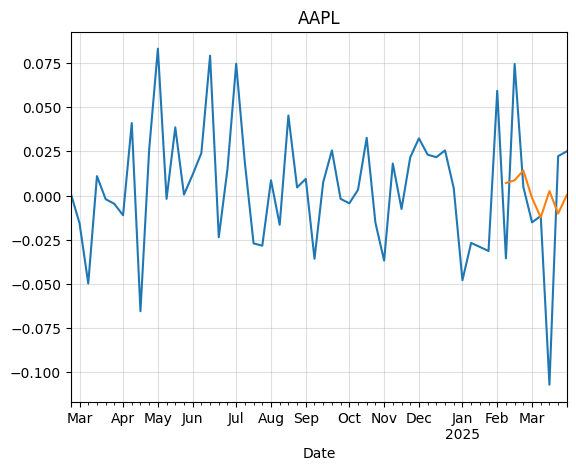

In [19]:
pd.concat([train_rets.iloc[-50:][symbol], val_rets[symbol]], axis=0).plot()
prediction_results_processed[symbol].plot()
plt.grid(alpha=.4)
plt.title(symbol)
plt.show()

In [20]:
weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])

linear_decay_w = (periods_to_forecast - weight_indexes + 1)/weight_indexes.sum()
lambda_ = 0.3
exponential_decay_w = np.exp(-lambda_*weight_indexes)/np.exp(-lambda_*weight_indexes).sum()

(exponential_decay_w, linear_decay_w)

(array([0.28504003, 0.21116285, 0.15643328, 0.11588863, 0.08585241,
        0.06360103, 0.0471168 , 0.03490498]),
 array([0.22222222, 0.19444444, 0.16666667, 0.13888889, 0.11111111,
        0.08333333, 0.05555556, 0.02777778]))

In [21]:
predicted_yearly_return = ((prediction_results_processed[symbol] + 1).prod()**(1/len(prediction_results_processed[symbol])))**(periods_per_year) - 1
linear_decay_predicted_yearly_return = (1 + np.sum(prediction_results_processed[symbol]*linear_decay_w))**periods_per_year - 1
exponential_decay_predicted_yearly_return = (1 + np.sum(prediction_results_processed[symbol]*exponential_decay_w))**periods_per_year - 1
historical_yearly_return = rk.summary_stats(train_rets[[symbol]][-108:], periods_per_year=periods_per_year)['Annualized Return'][0]
actual_yearly_return = ((val_rets[symbol] + 1).prod()**(1/len(val_rets[symbol])))**(periods_per_year) - 1

print(f'{predicted_yearly_return} - Predicted yearly returns')
print(f'{linear_decay_predicted_yearly_return} - Linear decay predicted yearly returns')
print(f'{exponential_decay_predicted_yearly_return} - Exponential decay predicted yearly returns')
print(f'{historical_yearly_return} - Historical yearly returns')
print(f'{actual_yearly_return} - Actual yearly returns')

0.06361849948491605 - Predicted yearly returns
0.22579600602400518 - Linear decay predicted yearly returns
0.28152305875832595 - Exponential decay predicted yearly returns
0.3564118659365685 - Historical yearly returns
-0.29698306404998553 - Actual yearly returns


In [22]:
preds_df = pd.DataFrame(prediction_results_processed)

# Average RMSE across all stocks
n8_periods_rmse = np.mean(np.sqrt(np.mean((preds_df - val_rets)**2, axis=0)))
n4_periods_rmse = np.mean(np.sqrt(np.mean((preds_df.iloc[:4] - val_rets.iloc[:4])**2, axis=0)))
n1_periods_rmse = np.mean(np.sqrt((preds_df.iloc[0] - val_rets.iloc[0])**2))

print(f'1 period RMSE: {n1_periods_rmse.round(6)}')
print(f'4 periods RMSE: {n4_periods_rmse.round(6)}')
print(f'8 periods RMSE: {n8_periods_rmse.round(6)}')

1 period RMSE: 0.036951
4 periods RMSE: 0.04725
8 periods RMSE: 0.04319


### **Estimate parameters for the VAR model**

In [24]:
train_rets.columns

Index(['BCOLOMBIA.CL', 'BOGOTA.CL', 'BVC.CL', 'CELSIA.CL', 'CEMARGOS.CL',
       'CNEC.CL', 'CONCONCRET.CL', 'CORFICOLCF.CL', 'ECOPETROL.CL', 'ENKA.CL',
       'ETB.CL', 'EXITO.CL', 'GEB.CL', 'GRUBOLIVAR.CL', 'GRUPOARGOS.CL',
       'GRUPOAVAL.CL', 'GRUPOSURA.CL', 'HCOLSEL.CL', 'ICOLCAP.CL', 'ISA.CL',
       'MINEROS.CL', 'NUTRESA.CL', 'PFAVAL.CL', 'PFBCOLOM.CL', 'PFCORFICOL.CL',
       'PFDAVVNDA.CL', 'PFGRUPOARG.CL', 'PFGRUPSURA.CL', 'PROMIGAS.CL',
       'TERPEL.CL', 'AAPL', 'AMZN', 'BAC', 'BRK-B', 'C', 'CBU7.L',
       'CENCOSUD.SN', 'CHILE.SN', 'CSPX.L', 'EIMI.L', 'F', 'FALABELLA.SN',
       'GE', 'GOOGL', 'JETS', 'JNJ', 'JPM', 'META', 'NKE', 'NVDA', 'PBR',
       'PFE', 'SGLD.L', 'VOO'],
      dtype='object')

In [25]:
symbols_selected = random.sample(list(train_rets.columns), 10)

In [26]:
symbols_selected

['PFGRUPSURA.CL',
 'JPM',
 'AMZN',
 'HCOLSEL.CL',
 'AAPL',
 'GRUPOARGOS.CL',
 'TERPEL.CL',
 'NUTRESA.CL',
 'SGLD.L',
 'PFDAVVNDA.CL']

In [27]:
# Compare the IC (Information Criteria) scores for VAR models of various number of lags to select the ideal number of lags
#varmod = VAR(train_rets)
varmod = VAR(train_rets_integrated[symbols_selected])
lag_sel = varmod.select_order(10)
print(lag_sel.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -59.38      -59.30   1.625e-26      -59.35
1       -62.48      -61.56   7.329e-28      -62.12
2       -63.93     -62.16*   1.729e-28      -63.23
3       -64.67      -62.06   8.239e-29      -63.65
4       -65.01      -61.56   5.877e-29     -63.66*
5       -65.24      -60.96   4.668e-29      -63.56
6       -65.48      -60.35   3.711e-29      -63.46
7       -65.51      -59.54   3.614e-29      -63.17
8      -65.54*      -58.74  3.526e-29*      -62.87
9       -65.51      -57.87   3.680e-29      -62.51
10      -65.52      -57.04   3.695e-29      -62.19
--------------------------------------------------


In [28]:
max_lags = lag_sel.aic

In [29]:
# Results of AIC for multiple VAR estimations suggest that 13 lags contain useful information for the 15 stocks selected
var_model = VAR(train_rets_integrated[symbols_selected]).fit(maxlags=max_lags, trend='c')
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Mar, 2025
Time:                     17:02:47
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -58.7978
Nobs:                     504.000    HQIC:                  -62.9221
Log likelihood:           10185.7    FPE:                3.38364e-29
AIC:                     -65.5841    Det(Omega_mle):     7.62309e-30
--------------------------------------------------------------------
Results for equation PFGRUPSURA.CL
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.000257         0.002360            0.109           0.913
L1.PFGRUPSURA.CL        -1.158704         0.069228          -16.737           0.000
L1.JPM                   0.006936       

In [30]:
# Test for absence of significant residual autocorrelations
test_corr = var_model.test_whiteness(nlags=22, signif=0.05, adjusted=False)
# There is no serial autocorrelation in residuals if p-value is more than 0.05
test_corr.pvalue

5.029867917413159e-11

In [31]:
# Check if the VAR model is stable
stest = var_model.is_stable()
# The model is stable if the result is True
stest

True

In [32]:
# Check 'PFGRUPOARG.CL' and 'PFGRUPSURA.CL'